## Project Milestone 4 - Linguistic Harbingers of Betrayal Extension

First, input all the libraries we need to get the plot:

In [1]:
import json

from scipy.stats import sem
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Since the data file contains only the selected games, there is no need to consider the selection criteria when retreving the message data. 
*The condition "relationships that contain at least two consecutive and reciprocated acts of support that span at least three seasons in game time, with no more than five seasons passing between two acts of friendship" is fullfilled.

Here, we read the data from json file and get the number of games, which is 500, including 250 selected games ended up betrayal and 250 selected games ended up lasting friendship between two players.


In [2]:
# read data from diplomacy_data.json with reading mode
with open("diplomacy_data.json", "r") as f:
        data = json.load(f)
len(data)

500

Since we only consider dialogs that happen before the last act of friendship, we need to know when does the last act of friendship happen. Later when extracting feature values, extract them from the seasons that is before the last support season.

In [3]:
# a function to get the season where the last support between two players happened
# entry refer to one entry in the dataset, one game
def last_support(entry):
    seasons = entry['seasons']
    last_support = None
    for season in seasons[:-1]:
        if 'support' in season['interaction'].values():
            last_support = season['season']
    return last_support

Given the messages sent by a player from a season in a game, we need to calculate the different variable values of the messages.

Variables we consider:

1. sent_pos: Positive sentiment
2. sent_neu: Neutral sentiment
3. sent_neg: Negative sentiment
4. discourse_comp: Discourse complexity (calculated through comparison, contingency, expansive and temporal)
5. plan: Planning level (calculated through future)
6. argu_level: Argumentation level (calculated through claim and premise)
7. n_request: Number of requests
8. politeness: Politeness
9. subj: Subjectivity
10. n_words: Number of words
11. n_sentences: Number of sentences


In [4]:
# a function to get the average value across the seasons for all features of the messages
# msgs: messages sent by a player from a season in a game
def extract_features(msgs):
    n_sents = sum(m['n_sentences'] for m in msgs) * 1.0
    if(n_sents==0.0):
        print(msgs)
    
    # Sentiment
    # compute positive sentiment score
    sent_pos = sum(m['sentiment'].get("positive") for m in msgs) / len(msgs)
    # compute neutral sentiment score
    sent_neu = sum(m['sentiment'].get("neutral") for m in msgs) / len(msgs)
    # compute positive sentiment score
    sent_neg = sum(m['sentiment'].get("negative") for m in msgs) / len(msgs)
    
    # Argumentation and Discourse
    # compute discourse complexity through comparison, contingency, expansive and temporal
    comparison = sum(len(m['lexicon_words'].get("disc_comparison", []))for m in msgs) / n_sents
    contingency = sum(len(m['lexicon_words'].get("disc_contingency", []))for m in msgs) / n_sents
    expansive = sum(len(m['lexicon_words'].get("disc_expansion", []))for m in msgs) / n_sents
    temporal = sum(len(m['lexicon_words'].get("disc_temporal_rest", []))for m in msgs) / n_sents
    discourse_comp = comparison+contingency+expansive+temporal
    # compute the average number of markers refer to future
    plan = sum(len(m['lexicon_words'].get("disc_temporal_future", []))for m in msgs) / n_sents
    # compute argumentation level through claim and premise
    claim = sum(len(m['lexicon_words'].get("claim", []))for m in msgs) / n_sents
    premise = sum(len(m['lexicon_words'].get("premise", []))for m in msgs) / n_sents
    argu_level = claim+premise
    # compute average number of request
    n_request = sum(m['n_requests'] for m in msgs) / len(msgs)
    
    # Politeness
    politeness = sum(m['politeness'] for m in msgs) / len(msgs)
    
    # Subjectivity using allsubj
    subj = sum(len(m['lexicon_words'].get("allsubj", []))for m in msgs) / n_sents
    
    # Talkativeness
    # compute average number of words
    n_words = sum(m['n_words'] for m in msgs) / len(msgs)
    # compute average number of sentences
    n_sentences = sum(m['n_sentences'] for m in msgs) / len(msgs)

    return np.array([sent_pos, sent_neu, sent_neg, discourse_comp, plan, argu_level, n_request, politeness, subj, n_words, n_sentences])

From paper: To ensure that we are studying conversational patterns that occur only when the two individuals in the dyad are ostensibly being friends, we only extract features from the messages exchanged before the last act of friendship.
Therefore, the messages we extract should from seasons less than last support season.

In [5]:
# a function to get average politeness scores from dataset entries 
# data: the dataset where we extract politeness score from
# betrayal: if the games we consider end up betrayal
# betrayer: if the person to be analyzed is the (potential) betrayer
def process_data(data, betrayal, betrayer):
    results = []

    # loop in every game in data
    for entry in data:
        len_seasons = len(entry['seasons'])                   
        # a matrix to store features of different seasons of one game
        data41game = np.zeros((len_seasons, 11))
        cut_ind = 0
        # none is used to check if the season contain any valuale msg
        none = True
                        
        if(entry['betrayal'] == betrayal):
            for i, season in enumerate(entry['seasons']):
                if(season['season'] <= last_support(entry)):
                    #if(len(season['messages']['betrayer']) > 0 and len(season['messages']['victim']) > 0):                
                    if(betrayer):
                        if(len(season['messages']['betrayer']) > 0 and sum(m['n_sentences'] for m in season['messages']['betrayer'])>0):
                            none = False
                            data41game[i,:] = extract_features(season['messages']['betrayer'])
                    else:
                        if(len(season['messages']['victim']) > 0):
                            none = False
                            data41game[i,:] = extract_features(season['messages']['victim'])
                else:
                    cut_ind = i
                    break
        
        # we consider only games where friendship lasts for at least four season
        if(cut_ind>4):
            # save only the four seasons before the last support
            data41game = data41game[cut_ind-4:cut_ind,:]
            # 
            if(none==False):
                data41game = data41game.flat
                results.append(data41game)        

    # return value is a list of features of the indicated player in the indicated type of games
    return results

Get the politeness score of the four conditions below:

In [6]:
# for the games end up betrayal, get politeness score for each betrayer
betray_er = pd.DataFrame(process_data(data, True, True))

# for the games end up betrayal, get politeness score for each victim
betray_vi = pd.DataFrame(process_data(data, True, False)) 

# for the games not end up betrayal, get politeness score for each potential betrayer
control_er = pd.DataFrame(process_data(data, False, True))

# for the games not end up betrayal, get politeness score for each potential victim
control_vi = pd.DataFrame(process_data(data, False, False)) 

In [7]:
betray_er

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,2.000000,2.5,2.000000,1.538462,0.307692,0.461538,5.500000,0.982703,4.384615,166.500000,...,0.666667,1.333333,0.500000,0.000000,0.166667,1.333333,0.761101,3.500000,35.666667,2.0
1,2.000000,3.0,4.500000,0.473684,0.105263,0.263158,4.500000,0.852683,2.736842,135.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.852749,1.500000,33.000000,4.0
2,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.322627,1.000000,26.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,2.000000,3.5,2.500000,0.312500,0.062500,0.125000,4.500000,0.698452,0.937500,80.000000,...,2.000000,2.000000,0.000000,0.000000,0.384615,3.500000,0.554453,1.538462,50.000000,6.5
4,1.000000,3.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.911976,0.800000,32.000000,...,1.000000,3.000000,0.666667,0.333333,0.333333,2.000000,0.975159,2.166667,59.000000,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
95,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
96,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.717932,4.000000,23.000000,1.0
97,1.000000,3.5,3.500000,0.312500,0.125000,0.250000,4.500000,0.602945,2.875000,133.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [8]:
betray_vi

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,1.000000,3.666667,4.666667,0.178571,0.035714,0.214286,3.666667,0.607331,1.571429,120.000000,...,1.500000,3.000000,0.363636,0.0,0.181818,2.000000,0.774352,2.181818,53.500000,5.5
1,0.000000,1.500000,5.000000,2.000000,0.538462,0.538462,5.000000,0.561690,3.230769,128.000000,...,4.000000,1.000000,1.166667,0.5,0.000000,3.000000,0.939752,2.833333,89.000000,6.0
2,0.000000,0.500000,0.500000,1.500000,0.500000,0.000000,1.000000,0.603157,5.500000,22.500000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.500000,0.000000,1.000000,3.666667,1.000000,0.000000,0.000000,0.845753,3.666667,35.500000,...,1.000000,2.000000,0.000000,0.0,0.333333,2.000000,0.931822,2.333333,47.000000,3.0
4,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.456725,0.750000,10.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.333333,0.333333,1.666667,0.142857,0.000000,0.857143,2.000000,0.473368,2.714286,42.666667,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
91,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
92,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
93,1.000000,0.666667,1.666667,0.200000,0.000000,0.400000,2.000000,0.696383,2.600000,45.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [9]:
control_er

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.0,2.0,0.00000,0.000000,1.000000,1.000000,0.596527,3.000000,77.0,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,5.000000,1.0
2,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.241535,1.500000,17.000000,2.0
4,1.666667,3.5,2.5,0.26087,0.043478,0.065217,2.666667,0.604672,1.847826,82.0,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.362865,2.000000,4.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1.000000,2.5,1.5,0.20000,0.000000,0.300000,2.000000,0.561422,1.700000,54.5,...,3.333333,2.666667,0.428571,0.000000,0.142857,2.666667,0.442122,1.047619,68.666667,7.0
111,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.500000,1.000000,0.666667,0.000000,0.666667,0.500000,0.562627,2.333333,19.500000,1.5
112,0.000000,0.0,1.0,0.00000,0.000000,0.000000,1.000000,0.698595,4.000000,12.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
113,0.000000,1.0,0.0,0.00000,0.000000,0.000000,1.000000,0.770494,8.000000,36.0,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.208446,1.000000,14.000000,1.0


In [10]:
control_vi

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.0,0.000000,0.0,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1,1.0,2.000000,1.0,0.75,0.000,0.500,2.0,0.368588,1.250000,59.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000,0.0,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
3,0.0,0.000000,0.0,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
4,0.0,0.000000,0.0,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,...,0.000000,4.0,0.000000,0.000000,0.333333,2.0,0.913732,1.833333,97.000000,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1.0,1.000000,2.0,0.75,0.125,0.375,3.0,0.427144,4.000000,85.5,...,1.333333,2.0,0.833333,0.166667,0.500000,3.0,0.799919,2.583333,68.333333,4.0
111,0.0,0.000000,0.0,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,...,0.000000,3.0,1.000000,0.333333,0.333333,3.0,0.591054,4.000000,75.000000,3.0
112,0.0,2.666667,1.0,0.00,0.000,0.000,1.0,0.445574,1.272727,29.0,...,2.000000,4.0,0.333333,0.000000,0.000000,3.0,0.788146,1.000000,56.000000,6.0
113,0.0,2.000000,2.0,0.75,0.000,0.000,1.0,0.754371,2.750000,80.0,...,0.500000,2.5,0.625000,0.375000,0.500000,1.0,0.627844,2.250000,44.000000,4.0


In [11]:
#label betrayal is 1
betray_er[44]=1

In [12]:
#label betrayal is 1
betray_vi[44]=1

In [13]:
# label non-betrayal is 0
control_er[44]=0

In [14]:
# label non-betrayal is 0
control_vi[44]=0

In [15]:
frames = [betray_er, betray_vi, control_er,control_vi]
 
betrayall_data = pd.concat(frames)

In [16]:
betrayall_data

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,2.0,2.500000,2.0,1.538462,0.307692,0.461538,5.5,0.982703,4.384615,166.5,...,1.333333,0.500000,0.000000,0.166667,1.333333,0.761101,3.500000,35.666667,2.0,1
1,2.0,3.000000,4.5,0.473684,0.105263,0.263158,4.5,0.852683,2.736842,135.0,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.852749,1.500000,33.000000,4.0,1
2,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.322627,1.000000,26.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
3,2.0,3.500000,2.5,0.312500,0.062500,0.125000,4.5,0.698452,0.937500,80.0,...,2.000000,0.000000,0.000000,0.384615,3.500000,0.554453,1.538462,50.000000,6.5,1
4,1.0,3.000000,1.0,0.000000,0.000000,0.000000,0.0,0.911976,0.800000,32.0,...,3.000000,0.666667,0.333333,0.333333,2.000000,0.975159,2.166667,59.000000,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1.0,1.000000,2.0,0.750000,0.125000,0.375000,3.0,0.427144,4.000000,85.5,...,2.000000,0.833333,0.166667,0.500000,3.000000,0.799919,2.583333,68.333333,4.0,0
111,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,3.000000,1.000000,0.333333,0.333333,3.000000,0.591054,4.000000,75.000000,3.0,0
112,0.0,2.666667,1.0,0.000000,0.000000,0.000000,1.0,0.445574,1.272727,29.0,...,4.000000,0.333333,0.000000,0.000000,3.000000,0.788146,1.000000,56.000000,6.0,0
113,0.0,2.000000,2.0,0.750000,0.000000,0.000000,1.0,0.754371,2.750000,80.0,...,2.500000,0.625000,0.375000,0.500000,1.000000,0.627844,2.250000,44.000000,4.0,0


In [17]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [18]:
[train, test] = split_set(betrayall_data)

In [19]:
train_x=train.drop(columns=[44])
train_y=train[44]

In [20]:
train_y

0      1
1      1
2      1
3      1
4      1
      ..
337    0
338    0
339    0
340    0
341    0
Name: 44, Length: 342, dtype: int64

In [21]:
test_x=test.drop(columns=[44])
test_y=test[44]

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

In [23]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')


def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [24]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_x,train_y)

LogisticRegression(max_iter=10000)

In [25]:
prediction_proba = logistic.predict_proba(test_x)

Text(0.5, 1.0, 'Confusion matrix for a 0.5 threshold')

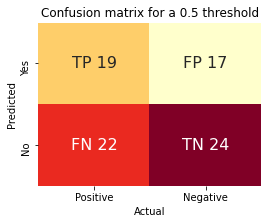

In [26]:
confusion_matrix_05 = compute_confusion_matrix(test_y, prediction_proba, 0.5 )
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')

In [27]:
[t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix_05)

print("The accuracy of this model is {0:1.3f}".format(accuracy))
print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))

The accuracy of this model is 0.524
For the positive case, the precision is 0.528, the recall is 0.463 and the F1 score is 0.494
For the negative case, the precision is 0.522, the recall is 0.585 and the F1 score is 0.552


In [28]:
betray_er

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,2.000000,2.5,2.000000,1.538462,0.307692,0.461538,5.500000,0.982703,4.384615,166.500000,...,1.333333,0.500000,0.000000,0.166667,1.333333,0.761101,3.500000,35.666667,2.0,1
1,2.000000,3.0,4.500000,0.473684,0.105263,0.263158,4.500000,0.852683,2.736842,135.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.852749,1.500000,33.000000,4.0,1
2,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.322627,1.000000,26.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
3,2.000000,3.5,2.500000,0.312500,0.062500,0.125000,4.500000,0.698452,0.937500,80.000000,...,2.000000,0.000000,0.000000,0.384615,3.500000,0.554453,1.538462,50.000000,6.5,1
4,1.000000,3.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.911976,0.800000,32.000000,...,3.000000,0.666667,0.333333,0.333333,2.000000,0.975159,2.166667,59.000000,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
95,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
96,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.717932,4.000000,23.000000,1.0,1
97,1.000000,3.5,3.500000,0.312500,0.125000,0.250000,4.500000,0.602945,2.875000,133.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1


In [29]:
betray_vi

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.000000,3.666667,4.666667,0.178571,0.035714,0.214286,3.666667,0.607331,1.571429,120.000000,...,3.000000,0.363636,0.0,0.181818,2.000000,0.774352,2.181818,53.500000,5.5,1
1,0.000000,1.500000,5.000000,2.000000,0.538462,0.538462,5.000000,0.561690,3.230769,128.000000,...,1.000000,1.166667,0.5,0.000000,3.000000,0.939752,2.833333,89.000000,6.0,1
2,0.000000,0.500000,0.500000,1.500000,0.500000,0.000000,1.000000,0.603157,5.500000,22.500000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
3,0.500000,0.000000,1.000000,3.666667,1.000000,0.000000,0.000000,0.845753,3.666667,35.500000,...,2.000000,0.000000,0.0,0.333333,2.000000,0.931822,2.333333,47.000000,3.0,1
4,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.456725,0.750000,10.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.333333,0.333333,1.666667,0.142857,0.000000,0.857143,2.000000,0.473368,2.714286,42.666667,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
91,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
92,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
93,1.000000,0.666667,1.666667,0.200000,0.000000,0.400000,2.000000,0.696383,2.600000,45.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1


In [30]:
control_er

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
1,0.000000,0.0,2.0,0.00000,0.000000,1.000000,1.000000,0.596527,3.000000,77.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,5.000000,1.0,0
2,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
3,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.241535,1.500000,17.000000,2.0,0
4,1.666667,3.5,2.5,0.26087,0.043478,0.065217,2.666667,0.604672,1.847826,82.0,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.362865,2.000000,4.000000,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1.000000,2.5,1.5,0.20000,0.000000,0.300000,2.000000,0.561422,1.700000,54.5,...,2.666667,0.428571,0.000000,0.142857,2.666667,0.442122,1.047619,68.666667,7.0,0
111,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1.000000,0.666667,0.000000,0.666667,0.500000,0.562627,2.333333,19.500000,1.5,0
112,0.000000,0.0,1.0,0.00000,0.000000,0.000000,1.000000,0.698595,4.000000,12.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
113,0.000000,1.0,0.0,0.00000,0.000000,0.000000,1.000000,0.770494,8.000000,36.0,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.208446,1.000000,14.000000,1.0,0


In [31]:
control_vi

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.0,0.000000,0.0,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0
1,1.0,2.000000,1.0,0.75,0.000,0.500,2.0,0.368588,1.250000,59.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0
2,0.0,0.000000,0.0,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0
3,0.0,0.000000,0.0,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0
4,0.0,0.000000,0.0,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,...,4.0,0.000000,0.000000,0.333333,2.0,0.913732,1.833333,97.000000,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1.0,1.000000,2.0,0.75,0.125,0.375,3.0,0.427144,4.000000,85.5,...,2.0,0.833333,0.166667,0.500000,3.0,0.799919,2.583333,68.333333,4.0,0
111,0.0,0.000000,0.0,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,...,3.0,1.000000,0.333333,0.333333,3.0,0.591054,4.000000,75.000000,3.0,0
112,0.0,2.666667,1.0,0.00,0.000,0.000,1.0,0.445574,1.272727,29.0,...,4.0,0.333333,0.000000,0.000000,3.0,0.788146,1.000000,56.000000,6.0,0
113,0.0,2.000000,2.0,0.75,0.000,0.000,1.0,0.754371,2.750000,80.0,...,2.5,0.625000,0.375000,0.500000,1.0,0.627844,2.250000,44.000000,4.0,0


In [32]:

from scipy.stats import sem
betray_er_sent_pos=[betray_er[0].mean(),betray_er[11].mean(),betray_er[22].mean(),betray_er[33].mean()]
betray_er_sent_neu=[betray_er[1].mean(),betray_er[12].mean(),betray_er[23].mean(),betray_er[34].mean()]
betray_er_sent_neg=[betray_er[2].mean(),betray_er[13].mean(),betray_er[24].mean(),betray_er[35].mean()]
betray_er_discourse_comp=[betray_er[3].mean(),betray_er[14].mean(),betray_er[25].mean(),betray_er[36].mean()]
betray_er_plan=[betray_er[4].mean(),betray_er[15].mean(),betray_er[26].mean(),betray_er[37].mean()]
betray_er_argu_level=[betray_er[5].mean(),betray_er[16].mean(),betray_er[27].mean(),betray_er[38].mean()]
betray_er_n_request=[betray_er[6].mean(),betray_er[17].mean(),betray_er[28].mean(),betray_er[39].mean()]
betray_er_politeness=[betray_er[7].mean(),betray_er[18].mean(),betray_er[29].mean(),betray_er[40].mean()]
betray_er_subj=[betray_er[8].mean(),betray_er[19].mean(),betray_er[30].mean(),betray_er[41].mean()]
betray_er_n_words=[betray_er[9].mean(),betray_er[20].mean(),betray_er[31].mean(),betray_er[42].mean()]
betray_er_n_sentences=[betray_er[10].mean(),betray_er[21].mean(),betray_er[32].mean(),betray_er[43].mean()]
season=[0,1,2,3]

In [33]:
betray_er_sent_pos_sem=[sem(betray_er[0]),sem(betray_er[11]),sem(betray_er[22]),sem(betray_er[33])]
betray_er_sent_neu_sem=[sem(betray_er[1]),sem(betray_er[12]),sem(betray_er[23]),sem(betray_er[34])]
betray_er_sent_neg_sem=[sem(betray_er[2]),sem(betray_er[13]),sem(betray_er[24]),sem(betray_er[35])]
betray_er_discourse_comp_sem=[sem(betray_er[3]),sem(betray_er[14]),sem(betray_er[25]),sem(betray_er[36])]
betray_er_plan_sem=[sem(betray_er[4]),sem(betray_er[15]),sem(betray_er[26]),sem(betray_er[37])]
betray_er_argu_level_sem=[sem(betray_er[5]),sem(betray_er[16]),sem(betray_er[27]),sem(betray_er[38])]
betray_er_n_request_sem=[sem(betray_er[6]),sem(betray_er[17]),sem(betray_er[28]),sem(betray_er[39])]
betray_er_politeness_sem=[sem(betray_er[7]),sem(betray_er[18]),sem(betray_er[29]),sem(betray_er[40])]
betray_er_subj_sem=[sem(betray_er[8]),sem(betray_er[19]),sem(betray_er[30]),sem(betray_er[41])]
betray_er_n_words_sem=[sem(betray_er[9]),sem(betray_er[20]),sem(betray_er[31]),sem(betray_er[42])]
betray_er_n_sentences_sem=[sem(betray_er[10]),sem(betray_er[21]),sem(betray_er[32]),sem(betray_er[43])]

In [34]:
betray_vi_sent_pos=[betray_vi[0].mean(),betray_vi[11].mean(),betray_vi[22].mean(),betray_vi[33].mean()]
betray_vi_sent_neu=[betray_vi[1].mean(),betray_vi[12].mean(),betray_vi[23].mean(),betray_vi[34].mean()]
betray_vi_sent_neg=[betray_vi[2].mean(),betray_vi[13].mean(),betray_vi[24].mean(),betray_vi[35].mean()]
betray_vi_discourse_comp=[betray_vi[3].mean(),betray_vi[14].mean(),betray_vi[25].mean(),betray_vi[36].mean()]
betray_vi_plan=[betray_vi[4].mean(),betray_vi[15].mean(),betray_vi[26].mean(),betray_vi[37].mean()]
betray_vi_argu_level=[betray_vi[5].mean(),betray_vi[16].mean(),betray_vi[27].mean(),betray_vi[38].mean()]
betray_vi_n_request=[betray_vi[6].mean(),betray_vi[17].mean(),betray_vi[28].mean(),betray_vi[39].mean()]
betray_vi_politeness=[betray_vi[7].mean(),betray_vi[18].mean(),betray_vi[29].mean(),betray_vi[40].mean()]
betray_vi_subj=[betray_vi[8].mean(),betray_vi[19].mean(),betray_vi[30].mean(),betray_vi[41].mean()]
betray_vi_n_words=[betray_vi[9].mean(),betray_vi[20].mean(),betray_vi[31].mean(),betray_vi[42].mean()]
betray_vi_n_sentences=[betray_vi[10].mean(),betray_vi[21].mean(),betray_vi[32].mean(),betray_vi[43].mean()]

In [35]:
betray_vi_sent_pos_sem=[sem(betray_vi[0]),sem(betray_vi[11]),sem(betray_vi[22]),sem(betray_vi[33])]
betray_vi_sent_neu_sem=[sem(betray_vi[1]),sem(betray_vi[12]),sem(betray_vi[23]),sem(betray_vi[34])]
betray_vi_sent_neg_sem=[sem(betray_vi[2]),sem(betray_vi[13]),sem(betray_vi[24]),sem(betray_vi[35])]
betray_vi_discourse_comp_sem=[sem(betray_vi[3]),sem(betray_vi[14]),sem(betray_vi[25]),sem(betray_vi[36])]
betray_vi_plan_sem=[sem(betray_vi[4]),sem(betray_vi[15]),sem(betray_vi[26]),sem(betray_vi[37])]
betray_vi_argu_level_sem=[sem(betray_vi[5]),sem(betray_vi[16]),sem(betray_vi[27]),sem(betray_vi[38])]
betray_vi_n_request_sem=[sem(betray_vi[6]),sem(betray_vi[17]),sem(betray_vi[28]),sem(betray_vi[39])]
betray_vi_politeness_sem=[sem(betray_vi[7]),sem(betray_vi[18]),sem(betray_vi[29]),sem(betray_vi[40])]
betray_vi_subj_sem=[sem(betray_vi[8]),sem(betray_vi[19]),sem(betray_vi[30]),sem(betray_vi[41])]
betray_vi_n_words_sem=[sem(betray_vi[9]),sem(betray_vi[20]),sem(betray_vi[31]),sem(betray_vi[42])]
betray_vi_n_sentences_sem=[sem(betray_vi[10]),sem(betray_vi[21]),sem(betray_vi[32]),sem(betray_vi[43])]

In [36]:
control_er_sent_pos=[control_er[0].mean(),control_er[11].mean(),control_er[22].mean(),control_er[33].mean()]
control_er_sent_neu=[control_er[1].mean(),control_er[12].mean(),control_er[23].mean(),control_er[34].mean()]
control_er_sent_neg=[control_er[2].mean(),control_er[13].mean(),control_er[24].mean(),control_er[35].mean()]
control_er_discourse_comp=[control_er[3].mean(),control_er[14].mean(),control_er[25].mean(),control_er[36].mean()]
control_er_plan=[control_er[4].mean(),control_er[15].mean(),control_er[26].mean(),control_er[37].mean()]
control_er_argu_level=[control_er[5].mean(),control_er[16].mean(),control_er[27].mean(),control_er[38].mean()]
control_er_n_request=[control_er[6].mean(),control_er[17].mean(),control_er[28].mean(),control_er[39].mean()]
control_er_politeness=[control_er[7].mean(),control_er[18].mean(),control_er[29].mean(),control_er[40].mean()]
control_er_subj=[control_er[8].mean(),control_er[19].mean(),control_er[30].mean(),control_er[41].mean()]
control_er_n_words=[control_er[9].mean(),control_er[20].mean(),control_er[31].mean(),control_er[42].mean()]
control_er_n_sentences=[control_er[10].mean(),control_er[21].mean(),control_er[32].mean(),control_er[43].mean()]

In [37]:
control_er_sent_pos_sem=[sem(control_er[0]),sem(control_er[11]),sem(control_er[22]),sem(control_er[33])]
control_er_sent_neu_sem=[sem(control_er[1]),sem(control_er[12]),sem(control_er[23]),sem(control_er[34])]
control_er_sent_neg_sem=[sem(control_er[2]),sem(control_er[13]),sem(control_er[24]),sem(control_er[35])]
control_er_discourse_comp_sem=[sem(control_er[3]),sem(control_er[14]),sem(control_er[25]),sem(control_er[36])]
control_er_plan_sem=[sem(control_er[4]),sem(control_er[15]),sem(control_er[26]),sem(control_er[37])]
control_er_argu_level_sem=[sem(control_er[5]),sem(control_er[16]),sem(control_er[27]),sem(control_er[38])]
control_er_n_request_sem=[sem(control_er[6]),sem(control_er[17]),sem(control_er[28]),sem(control_er[39])]
control_er_politeness_sem=[sem(control_er[7]),sem(control_er[18]),sem(control_er[29]),sem(control_er[40])]
control_er_subj_sem=[sem(control_er[8]),sem(control_er[19]),sem(control_er[30]),sem(control_er[41])]
control_er_n_words_sem=[sem(control_er[9]),sem(control_er[20]),sem(control_er[31]),sem(control_er[42])]
control_er_n_sentences_sem=[sem(control_er[10]),sem(control_er[21]),sem(control_er[32]),sem(control_er[43])]

In [38]:
control_vi_sent_pos=[control_vi[0].mean(),control_vi[11].mean(),control_vi[22].mean(),control_vi[33].mean()]
control_vi_sent_neu=[control_vi[1].mean(),control_vi[12].mean(),control_vi[23].mean(),control_vi[34].mean()]
control_vi_sent_neg=[control_vi[2].mean(),control_vi[13].mean(),control_vi[24].mean(),control_vi[35].mean()]
control_vi_discourse_comp=[control_vi[3].mean(),control_vi[14].mean(),control_vi[25].mean(),control_vi[36].mean()]
control_vi_plan=[control_vi[4].mean(),control_vi[15].mean(),control_vi[26].mean(),control_vi[37].mean()]
control_vi_argu_level=[control_vi[5].mean(),control_vi[16].mean(),control_vi[27].mean(),control_vi[38].mean()]
control_vi_n_request=[control_vi[6].mean(),control_vi[17].mean(),control_vi[28].mean(),control_vi[39].mean()]
control_vi_politeness=[control_vi[7].mean(),control_vi[18].mean(),control_vi[29].mean(),control_vi[40].mean()]
control_vi_subj=[control_vi[8].mean(),control_vi[19].mean(),control_vi[30].mean(),control_vi[41].mean()]
control_vi_n_words=[control_vi[9].mean(),control_vi[20].mean(),control_vi[31].mean(),control_vi[42].mean()]
control_vi_n_sentences=[control_vi[10].mean(),control_vi[21].mean(),control_vi[32].mean(),control_vi[43].mean()]

In [39]:
control_vi_sent_pos_sem=[sem(control_vi[0]),sem(control_vi[11]),sem(control_vi[22]),sem(control_vi[33])]
control_vi_sent_neu_sem=[sem(control_vi[1]),sem(control_vi[12]),sem(control_vi[23]),sem(control_vi[34])]
control_vi_sent_neg_sem=[sem(control_vi[2]),sem(control_vi[13]),sem(control_vi[24]),sem(control_vi[35])]
control_vi_discourse_comp_sem=[sem(control_vi[3]),sem(control_vi[14]),sem(control_vi[25]),sem(control_vi[36])]
control_vi_plan_sem=[sem(control_vi[4]),sem(control_vi[15]),sem(control_vi[26]),sem(control_vi[37])]
control_vi_argu_level_sem=[sem(control_vi[5]),sem(control_vi[16]),sem(control_vi[27]),sem(control_vi[38])]
control_vi_n_request_sem=[sem(control_vi[6]),sem(control_vi[17]),sem(control_vi[28]),sem(control_vi[39])]
control_vi_politeness_sem=[sem(control_vi[7]),sem(control_vi[18]),sem(control_vi[29]),sem(control_vi[40])]
control_vi_subj_sem=[sem(control_vi[8]),sem(control_vi[19]),sem(control_vi[30]),sem(control_vi[41])]
control_vi_n_words_sem=[sem(control_vi[9]),sem(control_vi[20]),sem(control_vi[31]),sem(control_vi[42])]
control_vi_n_sentences_sem=[sem(control_vi[10]),sem(control_vi[21]),sem(control_vi[32]),sem(control_vi[43])]

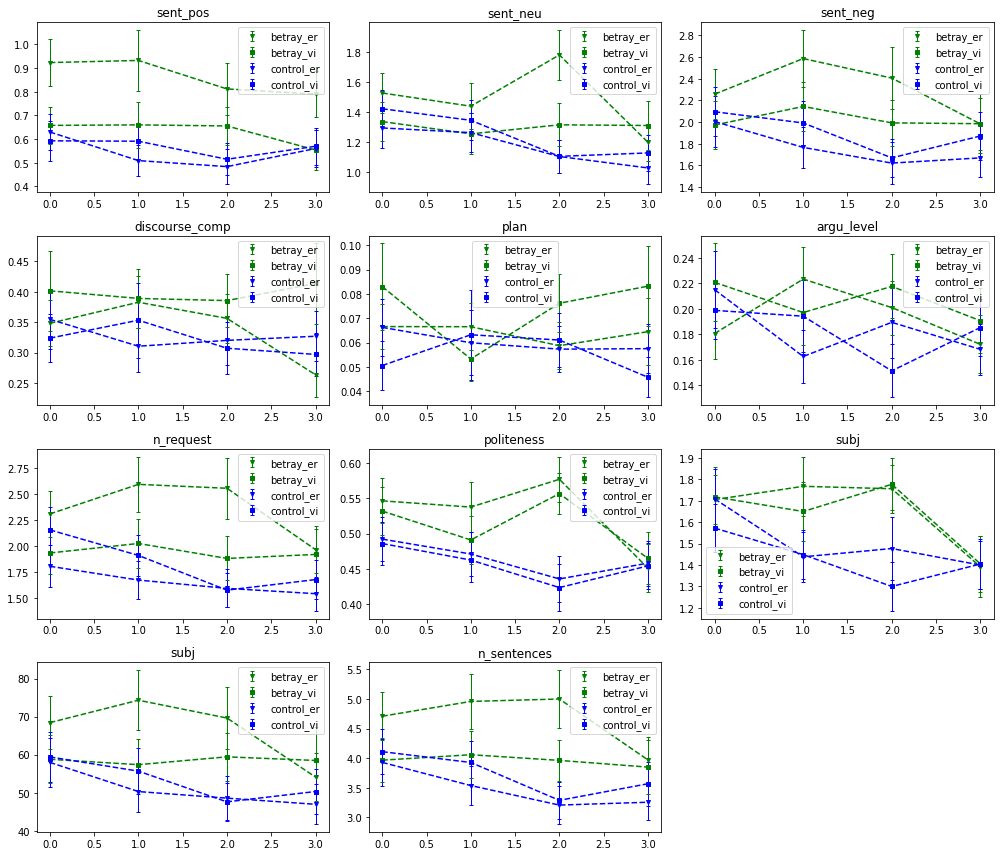

In [40]:
import matplotlib.gridspec as gridspec
f = plt.figure(tight_layout=True,figsize=(14,12))
# set the width ratio between the two subplots
gs = gridspec.GridSpec(4, 3)
#first graph
ax1 = plt.subplot(gs[0])  
ax1.plot(season, betray_er_sent_pos,'--',color='green');
ax1.errorbar(season,betray_er_sent_pos,yerr=betray_er_sent_pos_sem,fmt='v',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_er')
ax1.plot(season, betray_vi_sent_pos,'--',color='green');
ax1.errorbar(season,betray_vi_sent_pos,yerr=betray_vi_sent_pos_sem,fmt='s',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_vi')
ax1.plot(season, control_er_sent_pos,'--',color='blue');
ax1.errorbar(season,control_er_sent_pos,yerr=control_er_sent_pos_sem,fmt='v',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_er')
ax1.plot(season, control_vi_sent_pos,'--',color='blue');
ax1.errorbar(season,control_vi_sent_pos,yerr=control_vi_sent_pos_sem,fmt='s',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_vi')
ax1.set_title("sent_pos")
ax1.legend()
ax2 = plt.subplot(gs[1])  
ax2.plot(season, betray_er_sent_neu,'--',color='green');
ax2.errorbar(season,betray_er_sent_neu,yerr=betray_er_sent_neu_sem,fmt='v',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_er')
ax2.plot(season, betray_vi_sent_neu,'--',color='green');
ax2.errorbar(season,betray_vi_sent_neu,yerr=betray_vi_sent_neu_sem,fmt='s',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_vi')
ax2.plot(season, control_er_sent_neu,'--',color='blue');
ax2.errorbar(season,control_er_sent_neu,yerr=control_er_sent_neu_sem,fmt='v',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_er')
ax2.plot(season, control_vi_sent_neu,'--',color='blue');
ax2.errorbar(season,control_vi_sent_neu,yerr=control_vi_sent_neu_sem,fmt='s',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_vi')
ax2.set_title("sent_neu")
ax2.legend()
ax3 = plt.subplot(gs[2])  
ax3.plot(season, betray_er_sent_neg,'--',color='green');
ax3.errorbar(season,betray_er_sent_neg,yerr=betray_er_sent_neg_sem,fmt='v',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_er')
ax3.plot(season, betray_vi_sent_neg,'--',color='green');
ax3.errorbar(season,betray_vi_sent_neg,yerr=betray_vi_sent_neg_sem,fmt='s',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_vi')
ax3.plot(season, control_er_sent_neg,'--',color='blue');
ax3.errorbar(season,control_er_sent_neg,yerr=control_er_sent_neg_sem,fmt='v',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_er')
ax3.plot(season, control_vi_sent_neg,'--',color='blue');
ax3.errorbar(season,control_vi_sent_neg,yerr=control_vi_sent_neg_sem,fmt='s',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_vi')
ax3.set_title("sent_neg")
ax3.legend()
ax4 = plt.subplot(gs[3])  
ax4.plot(season, betray_er_discourse_comp,'--',color='green');
ax4.errorbar(season,betray_er_discourse_comp,yerr=betray_er_discourse_comp_sem,fmt='v',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_er')
ax4.plot(season, betray_vi_discourse_comp,'--',color='green');
ax4.errorbar(season,betray_vi_discourse_comp,yerr=betray_vi_discourse_comp_sem,fmt='s',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_vi')
ax4.plot(season, control_er_discourse_comp,'--',color='blue');
ax4.errorbar(season,control_er_discourse_comp,yerr=control_er_discourse_comp_sem,fmt='v',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_er')
ax4.plot(season, control_vi_discourse_comp,'--',color='blue');
ax4.errorbar(season,control_vi_discourse_comp,yerr=control_vi_discourse_comp_sem,fmt='s',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_vi')
ax4.set_title("discourse_comp")
ax4.legend()
ax4 = plt.subplot(gs[4])  
ax4.plot(season, betray_er_plan,'--',color='green');
ax4.errorbar(season,betray_er_plan,yerr=betray_er_plan_sem,fmt='v',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_er')
ax4.plot(season, betray_vi_plan,'--',color='green');
ax4.errorbar(season,betray_vi_plan,yerr=betray_vi_plan_sem,fmt='s',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_vi')
ax4.plot(season, control_er_plan,'--',color='blue');
ax4.errorbar(season,control_er_plan,yerr=control_er_plan_sem,fmt='v',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_er')
ax4.plot(season, control_vi_plan,'--',color='blue');
ax4.errorbar(season,control_vi_plan,yerr=control_vi_plan_sem,fmt='s',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_vi')
ax4.set_title("plan")
ax4.legend()
ax5 = plt.subplot(gs[5])  
ax5.plot(season, betray_er_argu_level,'--',color='green');
ax5.errorbar(season,betray_er_argu_level,yerr=betray_er_argu_level_sem,fmt='v',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_er')
ax5.plot(season, betray_vi_argu_level,'--',color='green');
ax5.errorbar(season,betray_vi_argu_level,yerr=betray_vi_argu_level_sem,fmt='s',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_vi')
ax5.plot(season, control_er_argu_level,'--',color='blue');
ax5.errorbar(season,control_er_argu_level,yerr=control_er_argu_level_sem,fmt='v',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_er')
ax5.plot(season, control_vi_argu_level,'--',color='blue');
ax5.errorbar(season,control_vi_argu_level,yerr=control_vi_argu_level_sem,fmt='s',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_vi')
ax5.set_title("argu_level")
ax5.legend()
ax6 = plt.subplot(gs[6])  
ax6.plot(season, betray_er_n_request,'--',color='green');
ax6.errorbar(season,betray_er_n_request,yerr=betray_er_n_request_sem,fmt='v',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_er')
ax6.plot(season, betray_vi_n_request,'--',color='green');
ax6.errorbar(season,betray_vi_n_request,yerr=betray_vi_n_request_sem,fmt='s',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_vi')
ax6.plot(season, control_er_n_request,'--',color='blue');
ax6.errorbar(season,control_er_n_request,yerr=control_er_n_request_sem,fmt='v',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_er')
ax6.plot(season, control_vi_n_request,'--',color='blue');
ax6.errorbar(season,control_vi_n_request,yerr=control_vi_n_request_sem,fmt='s',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_vi')
ax6.set_title("n_request")
ax6.legend()
ax7 = plt.subplot(gs[7])  
ax7.plot(season, betray_er_politeness,'--',color='green');
ax7.errorbar(season,betray_er_politeness,yerr=betray_er_politeness_sem,fmt='v',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_er')
ax7.plot(season, betray_vi_politeness,'--',color='green');
ax7.errorbar(season,betray_vi_politeness,yerr=betray_vi_politeness_sem,fmt='s',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_vi')
ax7.plot(season, control_er_politeness,'--',color='blue');
ax7.errorbar(season,control_er_politeness,yerr=control_er_politeness_sem,fmt='v',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_er')
ax7.plot(season, control_vi_politeness,'--',color='blue');
ax7.errorbar(season,control_vi_politeness,yerr=control_vi_politeness_sem,fmt='s',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_vi')
ax7.set_title("politeness")
ax7.legend()
ax8 = plt.subplot(gs[8])  
ax8.plot(season, betray_er_subj,'--',color='green');
ax8.errorbar(season,betray_er_subj,yerr=betray_er_subj_sem,fmt='v',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_er')
ax8.plot(season, betray_vi_subj,'--',color='green');
ax8.errorbar(season,betray_vi_subj,yerr=betray_vi_subj_sem,fmt='s',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_vi')
ax8.plot(season, control_er_subj,'--',color='blue');
ax8.errorbar(season,control_er_subj,yerr=control_er_subj_sem,fmt='v',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_er')
ax8.plot(season, control_vi_subj,'--',color='blue');
ax8.errorbar(season,control_vi_subj,yerr=control_vi_subj_sem,fmt='s',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_vi')
ax8.set_title("subj")
ax8.legend()
ax9 = plt.subplot(gs[9])  
ax9.plot(season, betray_er_n_words,'--',color='green');
ax9.errorbar(season,betray_er_n_words,yerr=betray_er_n_words_sem,fmt='v',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_er')
ax9.plot(season, betray_vi_n_words,'--',color='green');
ax9.errorbar(season,betray_vi_n_words,yerr=betray_vi_n_words_sem,fmt='s',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_vi')
ax9.plot(season, control_er_n_words,'--',color='blue');
ax9.errorbar(season,control_er_n_words,yerr=control_er_n_words_sem,fmt='v',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_er')
ax9.plot(season, control_vi_n_words,'--',color='blue');
ax9.errorbar(season,control_vi_n_words,yerr=control_vi_n_words_sem,fmt='s',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_vi')
ax9.set_title("subj")
ax9.legend()
ax10 = plt.subplot(gs[10])  
ax10.plot(season, betray_er_n_sentences,'--',color='green');
ax10.errorbar(season,betray_er_n_sentences,yerr=betray_er_n_sentences_sem,fmt='v',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_er')
ax10.plot(season, betray_vi_n_sentences,'--',color='green');
ax10.errorbar(season,betray_vi_n_sentences,yerr=betray_vi_n_sentences_sem,fmt='s',mec='green',mfc='green',ecolor='green',elinewidth=1,ms=4,capsize=2,label='betray_vi')
ax10.plot(season, control_er_n_sentences,'--',color='blue');
ax10.errorbar(season,control_er_n_sentences,yerr=control_er_n_sentences_sem,fmt='v',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_er')
ax10.plot(season, control_vi_n_sentences,'--',color='blue');
ax10.errorbar(season,control_vi_n_sentences,yerr=control_vi_n_sentences_sem,fmt='s',mec='blue',mfc='blue',ecolor='blue',elinewidth=1,ms=4,capsize=2,label='control_vi')
ax10.set_title("n_sentences")
ax10.legend()

In [41]:
# for the games end up betrayal, get politeness score for each betrayer
betray_er_1 = pd.DataFrame(process_data(data, True, True))

# for the games end up betrayal, get politeness score for each victim
betray_vi_1 = pd.DataFrame(process_data(data, True, False)) 

# for the games not end up betrayal, get politeness score for each potential betrayer
control_er_1 = pd.DataFrame(process_data(data, False, True))

# for the games not end up betrayal, get politeness score for each potential victim
control_vi_1 = pd.DataFrame(process_data(data, False, False)) 

In [42]:
betray_er_1[44]=1
betray_er_1

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,2.000000,2.5,2.000000,1.538462,0.307692,0.461538,5.500000,0.982703,4.384615,166.500000,...,1.333333,0.500000,0.000000,0.166667,1.333333,0.761101,3.500000,35.666667,2.0,1
1,2.000000,3.0,4.500000,0.473684,0.105263,0.263158,4.500000,0.852683,2.736842,135.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.852749,1.500000,33.000000,4.0,1
2,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.322627,1.000000,26.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
3,2.000000,3.5,2.500000,0.312500,0.062500,0.125000,4.500000,0.698452,0.937500,80.000000,...,2.000000,0.000000,0.000000,0.384615,3.500000,0.554453,1.538462,50.000000,6.5,1
4,1.000000,3.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.911976,0.800000,32.000000,...,3.000000,0.666667,0.333333,0.333333,2.000000,0.975159,2.166667,59.000000,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
95,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
96,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.717932,4.000000,23.000000,1.0,1
97,1.000000,3.5,3.500000,0.312500,0.125000,0.250000,4.500000,0.602945,2.875000,133.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1


In [43]:
betray_vi_1[44]=0
control_vi_1[44]=0
control_er_1[44]=0

In [44]:
frames_1 = [betray_er_1, betray_vi_1, control_vi_1, control_er_1]
 
betrayall_data_1 = pd.concat(frames_1)

In [45]:
betrayall_data_1

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,2.0,2.5,2.0,1.538462,0.307692,0.461538,5.5,0.982703,4.384615,166.5,...,1.333333,0.500000,0.000000,0.166667,1.333333,0.761101,3.500000,35.666667,2.0,1
1,2.0,3.0,4.5,0.473684,0.105263,0.263158,4.5,0.852683,2.736842,135.0,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.852749,1.500000,33.000000,4.0,1
2,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.322627,1.000000,26.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
3,2.0,3.5,2.5,0.312500,0.062500,0.125000,4.5,0.698452,0.937500,80.0,...,2.000000,0.000000,0.000000,0.384615,3.500000,0.554453,1.538462,50.000000,6.5,1
4,1.0,3.0,1.0,0.000000,0.000000,0.000000,0.0,0.911976,0.800000,32.0,...,3.000000,0.666667,0.333333,0.333333,2.000000,0.975159,2.166667,59.000000,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1.0,2.5,1.5,0.200000,0.000000,0.300000,2.0,0.561422,1.700000,54.5,...,2.666667,0.428571,0.000000,0.142857,2.666667,0.442122,1.047619,68.666667,7.0,0
111,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,1.000000,0.666667,0.000000,0.666667,0.500000,0.562627,2.333333,19.500000,1.5,0
112,0.0,0.0,1.0,0.000000,0.000000,0.000000,1.0,0.698595,4.000000,12.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
113,0.0,1.0,0.0,0.000000,0.000000,0.000000,1.0,0.770494,8.000000,36.0,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.208446,1.000000,14.000000,1.0,0


In [46]:
[train_1, test_1] = split_set(betrayall_data_1)
train_1_x=train_1.drop(columns=[44])
train_1_y=train_1[44]

In [47]:
test_1_x=test_1.drop(columns=[44])
test_1_y=test_1[44]

In [48]:
logistic_1 = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_1.fit(train_1_x,train_1_y)

LogisticRegression(max_iter=10000)

In [49]:
prediction_proba_1 = logistic_1.predict_proba(test_1_x)

Text(0.5, 1.0, 'Confusion matrix for a 0.5 threshold')

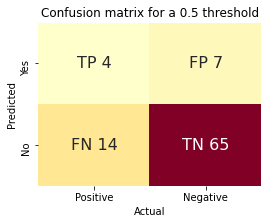

In [50]:
confusion_matrix_05 = compute_confusion_matrix(test_1_y, prediction_proba_1, 0.5 )
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')

In [51]:
[t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix_05)

print("The accuracy of this model is {0:1.3f}".format(accuracy))
print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))

The accuracy of this model is 0.767
For the positive case, the precision is 0.364, the recall is 0.222 and the F1 score is 0.276
For the negative case, the precision is 0.823, the recall is 0.903 and the F1 score is 0.861


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
rf= RandomForestClassifier(n_estimators=1000,max_depth=15,criterion='gini')
ridge = Ridge(alpha=6)
logistic = LogisticRegression(solver='lbfgs')
predicted = cross_validate(rf, betrayall_data_1.drop(columns=[44]), betrayall_data_1[44], cv=3)
np.mean(predicted['test_score'])

0.7406519495221922

In [53]:
predicted

{'fit_time': array([1.49619985, 1.48279095, 1.48608208]),
 'score_time': array([0.09239888, 0.09105206, 0.0898397 ]),
 'test_score': array([0.70422535, 0.75886525, 0.75886525])}

In [54]:
betrayall_data_1[betrayall_data_1[44]==0]

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.0,3.666667,4.666667,0.178571,0.035714,0.214286,3.666667,0.607331,1.571429,120.0,...,3.000000,0.363636,0.000000,0.181818,2.000000,0.774352,2.181818,53.500000,5.5,0
1,0.0,1.500000,5.000000,2.000000,0.538462,0.538462,5.000000,0.561690,3.230769,128.0,...,1.000000,1.166667,0.500000,0.000000,3.000000,0.939752,2.833333,89.000000,6.0,0
2,0.0,0.500000,0.500000,1.500000,0.500000,0.000000,1.000000,0.603157,5.500000,22.5,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
3,0.5,0.000000,1.000000,3.666667,1.000000,0.000000,0.000000,0.845753,3.666667,35.5,...,2.000000,0.000000,0.000000,0.333333,2.000000,0.931822,2.333333,47.000000,3.0,0
4,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.456725,0.750000,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1.0,2.500000,1.500000,0.200000,0.000000,0.300000,2.000000,0.561422,1.700000,54.5,...,2.666667,0.428571,0.000000,0.142857,2.666667,0.442122,1.047619,68.666667,7.0,0
111,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1.000000,0.666667,0.000000,0.666667,0.500000,0.562627,2.333333,19.500000,1.5,0
112,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.698595,4.000000,12.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
113,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.770494,8.000000,36.0,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.208446,1.000000,14.000000,1.0,0


In [57]:
from sklearn.model_selection import cross_val_score

In [58]:
precision = cross_val_score(rf, betrayall_data_1.drop(columns=[44]), betrayall_data_1[44], cv=6, scoring="precision")
recall = cross_val_score(rf, betrayall_data_1.drop(columns=[44]), betrayall_data_1[44], cv=6, scoring="recall")

# Precision: avoid false positives
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.02 (+/- 0.08)
Recall: 0.01 (+/- 0.04)


In [59]:
betrayall_data.drop(columns=[44])

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,2.0,2.500000,2.0,1.538462,0.307692,0.461538,5.5,0.982703,4.384615,166.5,...,0.666667,1.333333,0.500000,0.000000,0.166667,1.333333,0.761101,3.500000,35.666667,2.0
1,2.0,3.000000,4.5,0.473684,0.105263,0.263158,4.5,0.852683,2.736842,135.0,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.852749,1.500000,33.000000,4.0
2,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.322627,1.000000,26.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,2.0,3.500000,2.5,0.312500,0.062500,0.125000,4.5,0.698452,0.937500,80.0,...,2.000000,2.000000,0.000000,0.000000,0.384615,3.500000,0.554453,1.538462,50.000000,6.5
4,1.0,3.000000,1.0,0.000000,0.000000,0.000000,0.0,0.911976,0.800000,32.0,...,1.000000,3.000000,0.666667,0.333333,0.333333,2.000000,0.975159,2.166667,59.000000,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1.0,1.000000,2.0,0.750000,0.125000,0.375000,3.0,0.427144,4.000000,85.5,...,1.333333,2.000000,0.833333,0.166667,0.500000,3.000000,0.799919,2.583333,68.333333,4.0
111,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,3.000000,1.000000,0.333333,0.333333,3.000000,0.591054,4.000000,75.000000,3.0
112,0.0,2.666667,1.0,0.000000,0.000000,0.000000,1.0,0.445574,1.272727,29.0,...,2.000000,4.000000,0.333333,0.000000,0.000000,3.000000,0.788146,1.000000,56.000000,6.0
113,0.0,2.000000,2.0,0.750000,0.000000,0.000000,1.0,0.754371,2.750000,80.0,...,0.500000,2.500000,0.625000,0.375000,0.500000,1.000000,0.627844,2.250000,44.000000,4.0


In [61]:
from sklearn.manifold import TSNE
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(betrayall_data.drop(columns=[44]))

print("The features of the first sample are: %s" % X_reduced_tsne[0])

The features of the first sample are: [-4.8970957 18.857887 ]


In [63]:
from sklearn.decomposition import PCA
X_reduced_pca = PCA(n_components=2).fit(betrayall_data.drop(columns=[44])).transform(betrayall_data.drop(columns=[44]))

print("The features of the first sample are: %s" % X_reduced_pca[0])

The features of the first sample are: [  49.31543123 -100.43670269]


Text(0.5, 1.0, 'PCA')

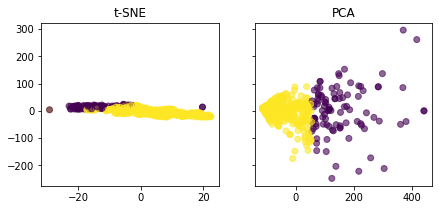

In [66]:
from sklearn.cluster import KMeans, DBSCAN
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

# Cluster the data in 3 groups
labels = KMeans(n_clusters=2, random_state=0).fit_predict(betrayall_data.drop(columns=[44]))

# Plot the data reduced in 2d space with t-SNE
axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[0].set_title("t-SNE")

# Plot the data reduced in 2d space with PCA
axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
axs[1].set_title("PCA")

Text(0.5, 1.0, 'Discovered clusters')

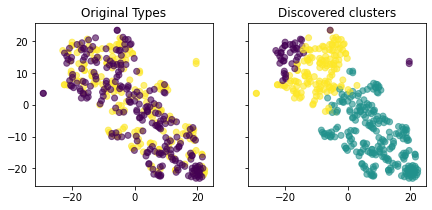

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=betrayall_data[44], alpha=0.6)
axs[0].set_title("Original Types")


labels = KMeans(n_clusters=3, random_state=0).fit_predict(betrayall_data.drop(columns=[44]))

axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[1].set_title("Discovered clusters")

In [70]:
from sklearn.preprocessing import StandardScaler
data_features=betrayall_data.drop(columns=[44])
scaled_features = StandardScaler().fit(data_features).transform(data_features)
print("Scaled sample: %s" %scaled_features[0])

Scaled sample: [ 1.4765955   0.82736341 -0.03454984  2.37738617  1.90093005  0.9552362
  1.58523292  1.44383691  2.07934287  1.5617662   0.58321408  1.19772524
 -0.36981381  0.04266741  1.17123865  1.03878325  0.38476503  0.51464036
  0.76874167  1.42723678  0.46101048  0.1769107   0.45642732 -0.22327454
 -0.40307429 -0.01459789  0.9605147   0.58218981  0.05497195  1.21819234
  1.23194963 -0.25655155 -0.2127654  -0.71262934 -0.37425818 -0.23029113
  0.37891968 -0.49546165 -0.05259587 -0.20578738  0.88569476  1.63108593
 -0.24574353 -0.4232749 ]


In [72]:
def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")

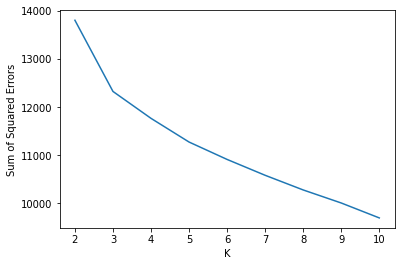

In [73]:
plot_sse(scaled_features)

In [75]:
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(scaled_features)

Text(0.5, 1.0, 'Discovered clusters')

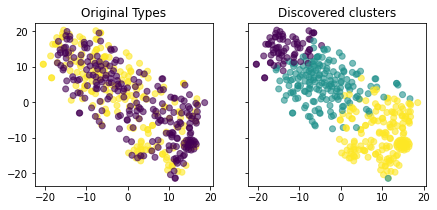

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=betrayall_data[44], alpha=0.6)
axs[0].set_title("Original Types")


labels = KMeans(n_clusters=3, random_state=0).fit_predict(scaled_features)

axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[1].set_title("Discovered clusters")

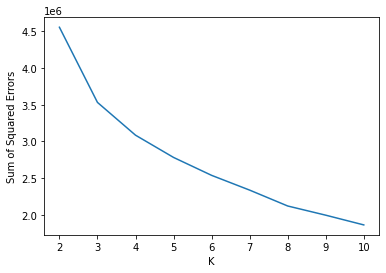

In [81]:
plot_sse(betrayall_data_1.drop(columns=[44]))